# Generalizing, Clustering and Summarizing Task Title

This ipython notebook is created for generalizing task in task title. I will be manually generalizing the task which has large amount of repeting keywords using Unigram and Bigram method. The rest of the data will be processed by clustering the task and summarizing the clustered task to get insight about the content of each cluster without having to look at it one by one.

#### *Import packages*

In [1]:
import pandas as pd
import numpy as np
import statistics
import nltk
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#### *Import dataframe*

In [ ]:
proms_df = pd.read_csv("CSV/PROMS_API_EXTRA.csv")
proms_df

In [3]:
proms_df.title = pd.read_csv("Stemmed_Result/stemmed_title.txt").title
proms_df.remarks = pd.read_csv("Stemmed_Result/stemmed_remarks.txt").remarks

#### *Check and remove any null values*

it is important to make sure that our data is free from null values. And when we remove them, we have to reset the index value to ensure that there is no skipped index numbers due to removal of the rows. Otherwise, the program will report error when running on the summarizing program when it reach a row which contains null values or missing row number. This is a very crucial step as I have run into this error while the program has run for 3 hours which is a waste of waiting time.

In [4]:
proms_df.isnull().sum()

title                 2
remarks               5
time_to_completion    0
complexity            0
related_parties       0
score                 0
created_at            0
office                0
division              0
word_count            0
dtype: int64

In [5]:
proms_df = proms_df[(proms_df.title.isnull() == False) & (proms_df.remarks.isnull() == False)].reset_index(drop=True)

In [6]:
proms_df.isnull().sum()

title                 0
remarks               0
time_to_completion    0
complexity            0
related_parties       0
score                 0
created_at            0
office                0
division              0
word_count            0
dtype: int64

In [7]:
proms_df.shape

(106386, 10)

## Generalizing task title manually

In this part, I will be generalizing tasks with the most common keywords from the existing task title. The reason behind this is because the most common task title can be easily identify manually. Doing manuall task genralization also help reduce the load of our computer to cluster and summarize our data.

#### *Frequency of each title*

In [ ]:
pd.DataFrame(proms_df.title.value_counts())

We can see that task title that contain call is more than 1. we could generalize all of them by the term "call". With the help of Unigram and Bigram, we can determine the most frequently used keywords to easily generalized the task titles.

#### *Unigram*

In [ ]:
tokenized_title = pd.Series(np.concatenate(list(proms_df.title.str.split())))

bahasaStopwords = StopWordRemoverFactory().get_stop_words()
clean_tokenized_title = tokenized_title[~tokenized_title.isin(bahasaStopwords)]

unigram_freq = pd.DataFrame(clean_tokenized_title).value_counts().sort_values(ascending=False)
unigram_freq

#### *Bigram*

In [ ]:
bigram = []
for value in proms_df.title:
    tokenized = value.split()
    tokenized = [word for word in tokenized if word not in bahasaStopwords]
    zipped = nltk.ngrams(tokenized, 2)
    lst = []
    for item in zipped:
        lst.append(item)
    bigram.extend(lst)

bigram_freq = pd.DataFrame(bigram).value_counts().sort_values(ascending=False)
bigram_freq

#### *Observing title values*

With generated Unigram and Bigram frequencies, we should observe the sentences that contains those frequent keywords in order to remove any mixed task titles. For example, when looking at "call", we can see that there are many other frequently used keywords such as "meeting", "concall", and many more, which should be on a different task title.

In [ ]:
observe_call = pd.DataFrame(proms_df.loc[proms_df.title.str.contains("call")].value_counts("title")).reset_index()
observe_hubung = pd.DataFrame(proms_df.loc[proms_df.title.str.contains("hubu")].value_counts("title").reset_index())
observe_telpon = pd.DataFrame(proms_df.loc[(proms_df.title.str.contains("telp")) | (proms_df.title.str.contains("tele"))].value_counts("title").reset_index())
observe_meeting = pd.DataFrame(proms_df.loc[proms_df.title.str.contains("meeting")].value_counts("title")).reset_index()
observe_transaction = pd.DataFrame(proms_df.loc[proms_df.title.str.contains("trans")].value_counts("title")).reset_index()
observe_update = pd.DataFrame(proms_df.loc[proms_df.title.str.contains("update")].value_counts("title")).reset_index()
observe_up = pd.DataFrame(proms_df.loc[proms_df.title.str.contains("up ")].value_counts("title")).reset_index()
observe_review = pd.DataFrame(proms_df.loc[proms_df.title.str.contains("review")].value_counts("title").reset_index())
observe_prospek = pd.DataFrame(proms_df.loc[proms_df.title.str.contains("prosp")].value_counts("title").reset_index())
observe_cl = pd.DataFrame(proms_df.loc[proms_df.title.str.contains("cl")].value_counts("title").reset_index())
observe_data = pd.DataFrame(proms_df.loc[proms_df.title.str.contains("data")].value_counts("title").reset_index())
observe_daily = pd.DataFrame(proms_df.loc[proms_df.title.str.contains("daily")].value_counts("title").reset_index())
observe_siar = pd.DataFrame(proms_df.loc[proms_df.title.str.contains("siar")].value_counts("title").reset_index())
observe_nav = pd.DataFrame(proms_df.loc[proms_df.title.str.contains("nav")].value_counts("title").reset_index())

observe_call

In [ ]:
observe_call[observe_call.title.str.contains("meeting")]

Above we can see that the keyword "call" is not purely a task called "call". when "call" is combine with "video" or "con", the actual meaning behind the task title changed. a video call or a concall are supposed to be categorized as "meeting"

#### *Renaming task titles*

After carefully selecting the task which falls under the same keyword category, we can rename them with the most general term possible that should explain the entire content of the task title and remarks.

In [13]:
proms_df.title.loc[(proms_df.title.str.contains("call")) |
                     (proms_df.title.str.contains("hubu")) |
                     (proms_df.title.str.contains("telp")) |
                     (proms_df.title.str.contains("tele")) &
                     (~proms_df.title.str.contains("meeting")) &
                     (~proms_df.title.str.contains("concall")) &
                     (~proms_df.title.str.contains("video")) &
                     (~proms_df.title.str.contains("conf")) &
                     (~proms_df.title.str.contains("con call")) &
                     (~proms_df.title.str.contains("extension")) &
                     (~proms_df.title.str.contains("telegram")) &
                     (~proms_df.title.str.contains("cek")) &
                     (~proms_df.title.str.contains("lapor")) &
                     (~proms_df.title.str.contains("review")) &
                     (~proms_df.title.str.contains("setting")) &
                     (~proms_df.title.str.contains("salur")) &
                     (~proms_df.title.str.contains("bisa")) &
                     (~proms_df.title.str.contains("surat")) &
                     (~proms_df.title.str.contains("troubleshoot")) &
                     (~proms_df.title.str.contains("mati")) &
                     (~proms_df.title.str.contains("ubah")) &
                     (~proms_df.title.str.contains("biaya")) &
                     (~proms_df.title.str.contains("input")) &
                     (~proms_df.title.str.contains("telecom")) &
                     (~proms_df.title.str.contains("tagih")) &
                     (~proms_df.title.str.contains("bank")) &
                     (~proms_df.title.str.contains("cek"))] = "call"

proms_df.title.loc[(proms_df.title.str.contains("meeting")) |
                     (proms_df.title.str.contains("concall")) |
                     (proms_df.title.str.contains("video call")) |
                     (proms_df.title.str.contains("confere")) |
                     (proms_df.title.str.contains("confr")) |
                     (proms_df.title.str.contains("con call")) |
                     (proms_df.title.str.contains("zoom"))] = "meeting"

proms_df.title.loc[proms_df.title.str.contains("trans")] = "transaction"
proms_df.title.loc[(proms_df.title.str.contains("update")) &
                     (~proms_df.title.str.contains("saldo"))] = "update"
proms_df.title.loc[(proms_df.title.str.contains("saldo"))] = "balance"
proms_df.title.loc[(proms_df.title.str.contains("up")) &
                     (proms_df.title.str.contains("follow"))] = "follow-up"
proms_df.title.loc[(proms_df.title.str.contains("visit")) |
                     (proms_df.title.str.contains("kunj"))] = "visit"
proms_df.title.loc[(proms_df.title.str.contains("prospek")) &
                     (~proms_df.title.str.contains("prospektus")) &
                     (~proms_df.title.str.contains("prospectus"))] = "prospect"
proms_df.title.loc[(proms_df.title.str.contains("review"))] = "review"
proms_df.title.loc[(proms_df.title.str.contains("cl")) &
                     (~proms_df.title.str.contains("cl[aiuoe]"))] = "confirmation-letter"
proms_df.title.loc[(proms_df.title.str.contains("data"))] = "data"
proms_df.title.loc[(proms_df.title.str.contains("daily"))] = "daily"

C:\Users\itlic\AppData\Local\Temp\ipykernel_14276\616080463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proms_df.title.loc[(proms_df.title.str.contains("call")) |
C:\Users\itlic\AppData\Local\Temp\ipykernel_14276\616080463.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proms_df.title.loc[(proms_df.title.str.contains("meeting")) |
C:\Users\itlic\AppData\Local\Temp\ipykernel_14276\616080463.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [ ]:
processed_title = proms_df.loc[proms_df.title.isin(["call", "meeting",  "transaction", "update", "balance",\
                                                        "follow-up", "visit", "prospect", "review", "confirmation-letter",\
                                                        "data", "daily"])].reset_index(drop=True)
processed_title.to_csv("CSV/processed_titles.csv", index=False)
processed_title

At this point, the task Unigram and Bigram frequency are no longer significantly bigger in comparison with the rest of it's values. We can now proceed to generelize our task titles with the help of clustering and summrizing.

## Generalizing Task Tittle By Clustering and Summarizing The 

#### *Separating the unprocessed titles from the processed titles*

In [ ]:
unprocessed_title = proms_df[~proms_df.title.isin(processed_title.title)]
unprocessed_title.to_csv("CSV/unprocessed_titles.csv", index=False)
unprocessed_title

#### *Clustering*

In theory, when clustering our data for job classification, we should use the sentences inside the column named remarks as they are the detailed description about what type of job it actually is.

In [16]:
vectorizer = TfidfVectorizer(stop_words=bahasaStopwords)
X = vectorizer.fit_transform(unprocessed_title.title)

#### *Elbow plot*

When we do not have any clue on how many clusters we should generate, generating elbow plot help us determine which number of cluster should we create

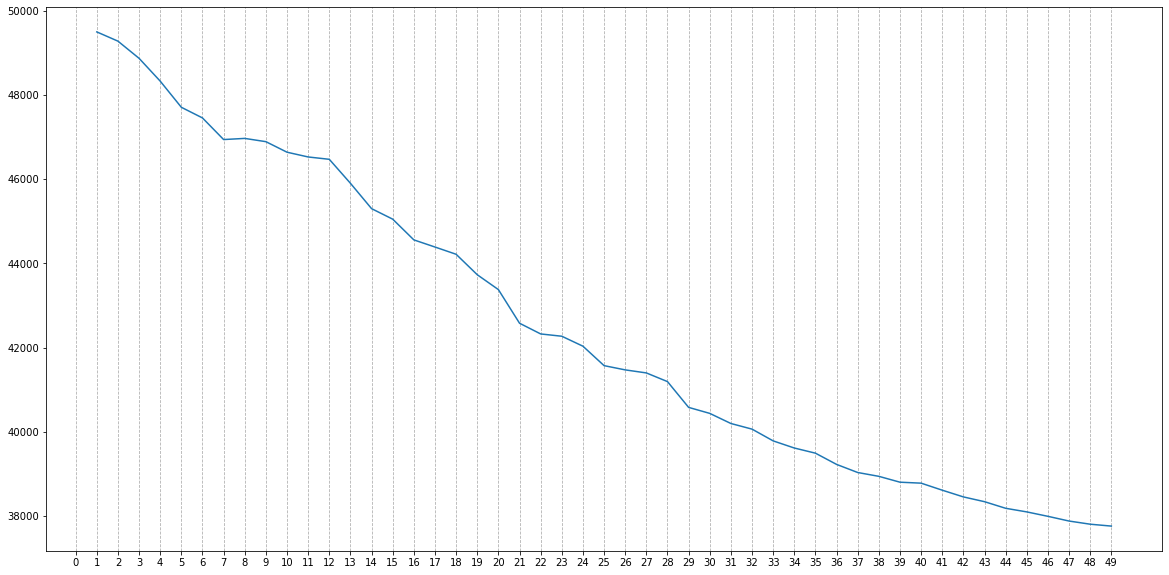

In [17]:
sse = []
for k in range(1, 50):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=126).fit(X)
    sse.append(km.inertia_)

plt.rcParams["figure.figsize"] = [20, 10] 
plt.plot(range(1, 50), sse)
plt.xticks(np.arange(0, 50, 1))
plt.grid(visible=True, axis="x", linestyle="--")

I decided to create a total of 4 clusters based on the elbow plot analysis

#### *Generating cluster group*

In [18]:
true_k = [7, 22, 29, 39]
clustered_df = pd.DataFrame({"title": unprocessed_title.title}).reset_index(drop=True)

for k in true_k:
    model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=126)
    clustered_df = pd.concat([clustered_df, pd.DataFrame({"cluster_" + str(k): model.fit_predict(X)})], axis=1)

# Save it to your local file directory so you don't have to repeat this process again in the future
clustered_df.to_csv("CSV/cluster_title_2.csv", index=False)

In [ ]:

clustered_title = pd.read_csv("CSV/cluster_title_2.csv")
clustered_title

#### *Distribution of cluster from each cluster group*

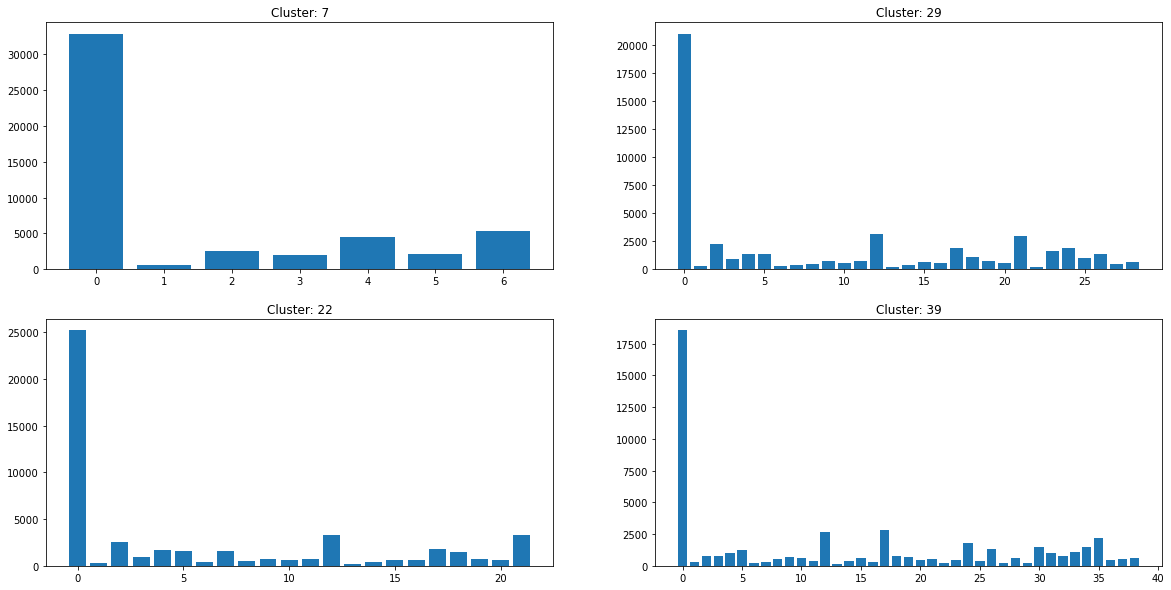

In [20]:
clusters = clustered_title.drop(columns=["title"]).columns.str.extract("(\d+)")[0]

fig = plt.figure(figsize=(np.ceil(np.sqrt(len(clusters)))*10, (np.ceil(np.sqrt(len(clusters)))-1)*10))
gs = GridSpec(nrows=int(np.ceil(np.sqrt(len(clusters)))), ncols=int(np.ceil(np.sqrt(len(clusters)))))
i = 0
j = 0

for cluster in clustered_title.drop(columns=["title"]).columns.str.extract("(\d+)")[0]:
    ax = fig.add_subplot(gs[i, j])
    i = i + 1
    if i > np.floor(np.sqrt(len(clusters)))-1:
        i = 0
        j = j + 1
    barplt_cluster = clustered_title["cluster_" + str(cluster)].value_counts().rename("freq").reset_index().rename(columns={"index": "cluster"})
    plt.bar(barplt_cluster.cluster, barplt_cluster.freq)
    plt.title("Cluster: {}".format(cluster))

plt.show()

#### *Summarizing text*

WARNING: depending on the amount of data that you process, it can take hours to process. Be sure to thouroughly process and do double check to your data preparation before running this program

In [ ]:
for clust in clustered_title.drop(columns=["title"]).columns.str.extract("(\d+)")[0]:
    print("Cluster group:", clust)
    for i in range(0, len(clustered_title["cluster_" + str(clust)].unique())):
        print("   Cluster number:", i)
        tokenized = pd.Series(np.concatenate(list(clustered_title[clustered_title["cluster_" + str(clust)] == i].title.str.split())))

        bahasaStopwords = StopWordRemoverFactory().get_stop_words()
        clean_tokenized = tokenized[~tokenized.isin(bahasaStopwords)]

        unigram = pd.DataFrame(pd.DataFrame(clean_tokenized).\
                               value_counts().\
                               sort_values(ascending=False)).\
                  rename(columns={0: "freq"}).reset_index().\
                  rename(columns={0: "word"})
        
        # print("   Number of unigram:", len(unigram))
                    
        points = []
        for j in range(0, len(clustered_title[clustered_title["cluster_" + str(clust)] == i].reset_index(drop=True).title.unique())):
            print("      Row number:", j)
            lst = []
            for k in range(0, len(unigram[unigram.freq > statistics.median(unigram.freq.unique())])):
                word = unigram[unigram.freq > statistics.median(unigram.freq.unique())].word[k]
                freq = unigram[unigram.freq > statistics.median(unigram.freq.unique())].freq[k]
                if word in pd.Series(clustered_title[clustered_title["cluster_" + str(clust)] == i].\
                                     reset_index(drop=True).title.unique())[j].split():
                    lst.append(freq)
            if len(lst) != 0:
                points.append(round(sum(lst)/len(lst)))
            else:
                points.append(0)

        pd.Series(points).rename("point").to_csv("CSV/Summarized_CSV/Cluster_" + str(clust) + "/title_" + str(clust) + "_" + str(i) + "_points.csv", index=False)
        
    print("")

## Result

In [ ]:
pd.read_csv("CSV/Summarized_CSV/Cluster_7/title_7_0_points.csv")